In [2]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "DejaVu Serif"
import matplotlib as mpl

# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"
from tqdm import tqdm
import gc
import os

Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indcies_Array = np.array(
    [117251, 300903, 324123, 329508, 382215, 400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3

Host_Index_At_99 = 329508
Host_Index_At_98 = 329045
Satellite_Index_At_98 = 329051



In [ ]:
Host_Tree=il.sublink.loadTree(basePath, 99, Host_Index_At_99, fields=['SnapNum','SubfindID'])
Satellite_Tree=il.sublink.loadTree(basePath, 98, Satellite_Index_At_98, fields=['SnapNum','SubfindID'])

In [ ]:
Host_Stellar_Mass_Array=np.array([])
Satellite_Stellar_Mass_Array=np.array([])

for Snapshot in range(Snapshot_Init,Snapshot_End):
    Host_Subfind_Index=Host_Tree['SubfindID'][np.where(Host_Tree['SnapNum']==Snapshot)[0][0]]
    Satellite_Subfind_Index=Satellite_Tree['SubfindID'][np.where(Satellite_Tree['SnapNum']==Snapshot)[0][0]]

    Host_Dict=il.groupcat.loadSingle(basePath, Snapshot, -1,Host_Subfind_Index)
    Satellite_Dict=il.groupcat.loadSingle(basePath, Snapshot, -1,Satellite_Subfind_Index)

    Host_Stellar_Mass=Host_Dict['SubhaloMassType'][4]*1e10/h
    Satellite_Stellar_Mass=Satellite_Dict['SubhaloMassType'][4]*1e10/h

    Host_Stellar_Mass_Array=np.append(Host_Stellar_Mass_Array,Host_Stellar_Mass)
    Satellite_Stellar_Mass_Array=np.append(Satellite_Stellar_Mass_Array,Satellite_Stellar_Mass)


In [ ]:
plt.figure(figsize=(6,4))
plt.plot(np.arange(Snapshot_Init,Snapshot_End),Host_Stellar_Mass_Array,label='Host')
plt.plot(np.arange(Snapshot_Init,Snapshot_End),Satellite_Stellar_Mass_Array,label='Satellite')
plt.plot(np.arange(Snapshot_Init,Snapshot_End),Host_Stellar_Mass_Array+Satellite_Stellar_Mass_Array,label='Total')
plt.legend()
plt.xlabel('Snapshot',usetex=True,fontsize=12)
plt.ylabel('Stellar Mass [$M_\odot$]',usetex=True,fontsize=12)
plt.title('Stellar Mass Evolution',usetex=True,fontsize=14)
plt.gca().invert_xaxis()
plt.grid()

---
SFR

In [ ]:
PartType0_Fields = ["Coordinates", "Masses", "StarFormationRate"]

Current_Snapshot = 99
Subhalo_Index = 329508
PartType0_Dict = il.snapshot.loadSubhalo(
    basePath, Current_Snapshot, Subhalo_Index, 0, PartType0_Fields)


In [13]:
class Cell:
    def __init__(self):
        self.Coordinate = np.array([0.0, 0.0, 0.0])
        self.Mass = 0.0


class Cloud:
    def __init__(self, x_range, y_range):
        x_min, x_max = x_range
        y_min, y_max = y_range
        x_centers = np.arange(x_min + 0.0625, x_max, 0.125)
        y_centers = np.arange(y_min + 0.0625, y_max, 0.125)
        xx, yy = np.meshgrid(x_centers, y_centers)
        self.cells = [Cell() for _ in range(xx.size)]
        self.x_range = x_range
        self.y_range = y_range
        self.assign_coordinates(xx.flatten(), yy.flatten())

    def assign_coordinates(self, x_coords, y_coords):
        for i, cell in enumerate(self.cells):
            cell.Coordinate = np.array([0.0, x_coords[i], y_coords[i]])

    def assign_mass(self, coordinates: np.ndarray, masses: np.ndarray):
        x_min, x_max = self.x_range
        y_min, y_max = self.y_range
        x_bars = int((x_max - x_min) / 0.125)
        for i in range(coordinates.shape[0]):
            coord = coordinates[i]
            mass = masses[i]
            x_index = int((coord[1] - x_min) / 0.125)
            y_index = int((coord[2] - y_min) / 0.125)

            index = y_index * x_bars + x_index
            if (index>= len(self.cells)):continue
            if (index<0):continue
            self.cells[index].Mass += mass

    def visualize(self, savePath):
        plt.figure(figsize=(20, 20), dpi=300)
        plt.style.use("dark_background")
        x_range, y_range = self.x_range, self.y_range
        plt.hist2d([cell.Coordinate[1] for cell in self.cells], [cell.Coordinate[2] for cell in self.cells], norm=mpl.colors.LogNorm(),cmin=0.00005, bins=[int((y_range[1]-y_range[0])*2), int((x_range[1]-x_range[0])*2)], weights=[cell.Mass for cell in self.cells])
        plt.xlabel('y [ckpc/h]')
        plt.ylabel('z [ckpc/h]')
        plt.ylim(self.x_range[0],self.x_range[1])
        plt.xlim(self.y_range[0],self.y_range[1])
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        plt.axis('equal')
        plt.savefig(savePath)
        plt.close('all')

    def reset(self):
        for cell in self.cells:
            cell.Coordinate = np.array([0.0, 0.0, 0.0])
            cell.Mass = 0.0

    def reset_mass(self):
        for cell in self.cells:
            cell.Mass = 0.0


In [9]:
y=20220
z=22040
total_range=300
ymin = y - total_range / 2
ymax = y + total_range / 2
zmin = z - total_range / 2
zmax = z + total_range / 2

cloud=Cloud([ymin,ymax],[zmin,zmax])

In [ ]:
cloud.assign_mass(PartType0_Dict['Coordinates'],PartType0_Dict['StarFormationRate'])

In [ ]:
plt.figure(figsize=(20, 20), dpi=300)
plt.style.use("dark_background")
x_range, y_range = cloud.x_range, cloud.y_range
plt.hist2d([cell.Coordinate[1] for cell in cloud.cells], [cell.Coordinate[2] for cell in cloud.cells], norm=mpl.colors.LogNorm(), bins=[int((x_range[1]-x_range[0])*8), int((y_range[1]-y_range[0])*8)], weights=[cell.Mass for cell in cloud.cells],cmin=1e-10,cmap='gray')
plt.xlabel('y [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.xlim(cloud.x_range[0],cloud.x_range[1])
plt.ylim(cloud.y_range[0],cloud.y_range[1])
#plt.axes().get_xaxis().set_visible(False)
#plt.axes().get_yaxis().set_visible(False)
plt.axis('equal')

---
Cold Gas

In [4]:
cell_data=il.snapshot.loadSubhalo(basePath, 99,329508, 'gas', fields=['Coordinates','Masses','ElectronAbundance','InternalEnergy','Masses'])

GasCoordinates = cell_data['Coordinates'].astype(np.float64)
Masses = cell_data['Masses'].astype(np.float64)
x_e=cell_data['ElectronAbundance'].astype(np.float64)
internal_energy=cell_data['InternalEnergy'].astype(np.float64)
gas_cell_masses=cell_data['Masses'].astype(np.float64)

m_p=1.673E-24
X_H=0.76
unit_switching=1E10
mean_molecular_weight=4*m_p/(1+3*X_H+4*X_H*x_e)
k_B=1.38E-16
gas_cell_temperature_in_Kelvin=2/3*internal_energy/k_B*unit_switching*mean_molecular_weight


In [24]:
gas_indices=np.where((gas_cell_temperature_in_Kelvin<1E4))[0]
gas_indices.shape

(539762,)

In [14]:
y=20220
z=22040
total_range=300
ymin = y - total_range / 2
ymax = y + total_range / 2
zmin = z - total_range / 2
zmax = z + total_range / 2

cloud=Cloud([ymin,ymax],[zmin,zmax])

In [26]:
cloud.reset_mass()
cloud.assign_mass(GasCoordinates[gas_indices],Masses[gas_indices])

(20070.0625, 20369.9375, 21890.0625, 22189.9375)

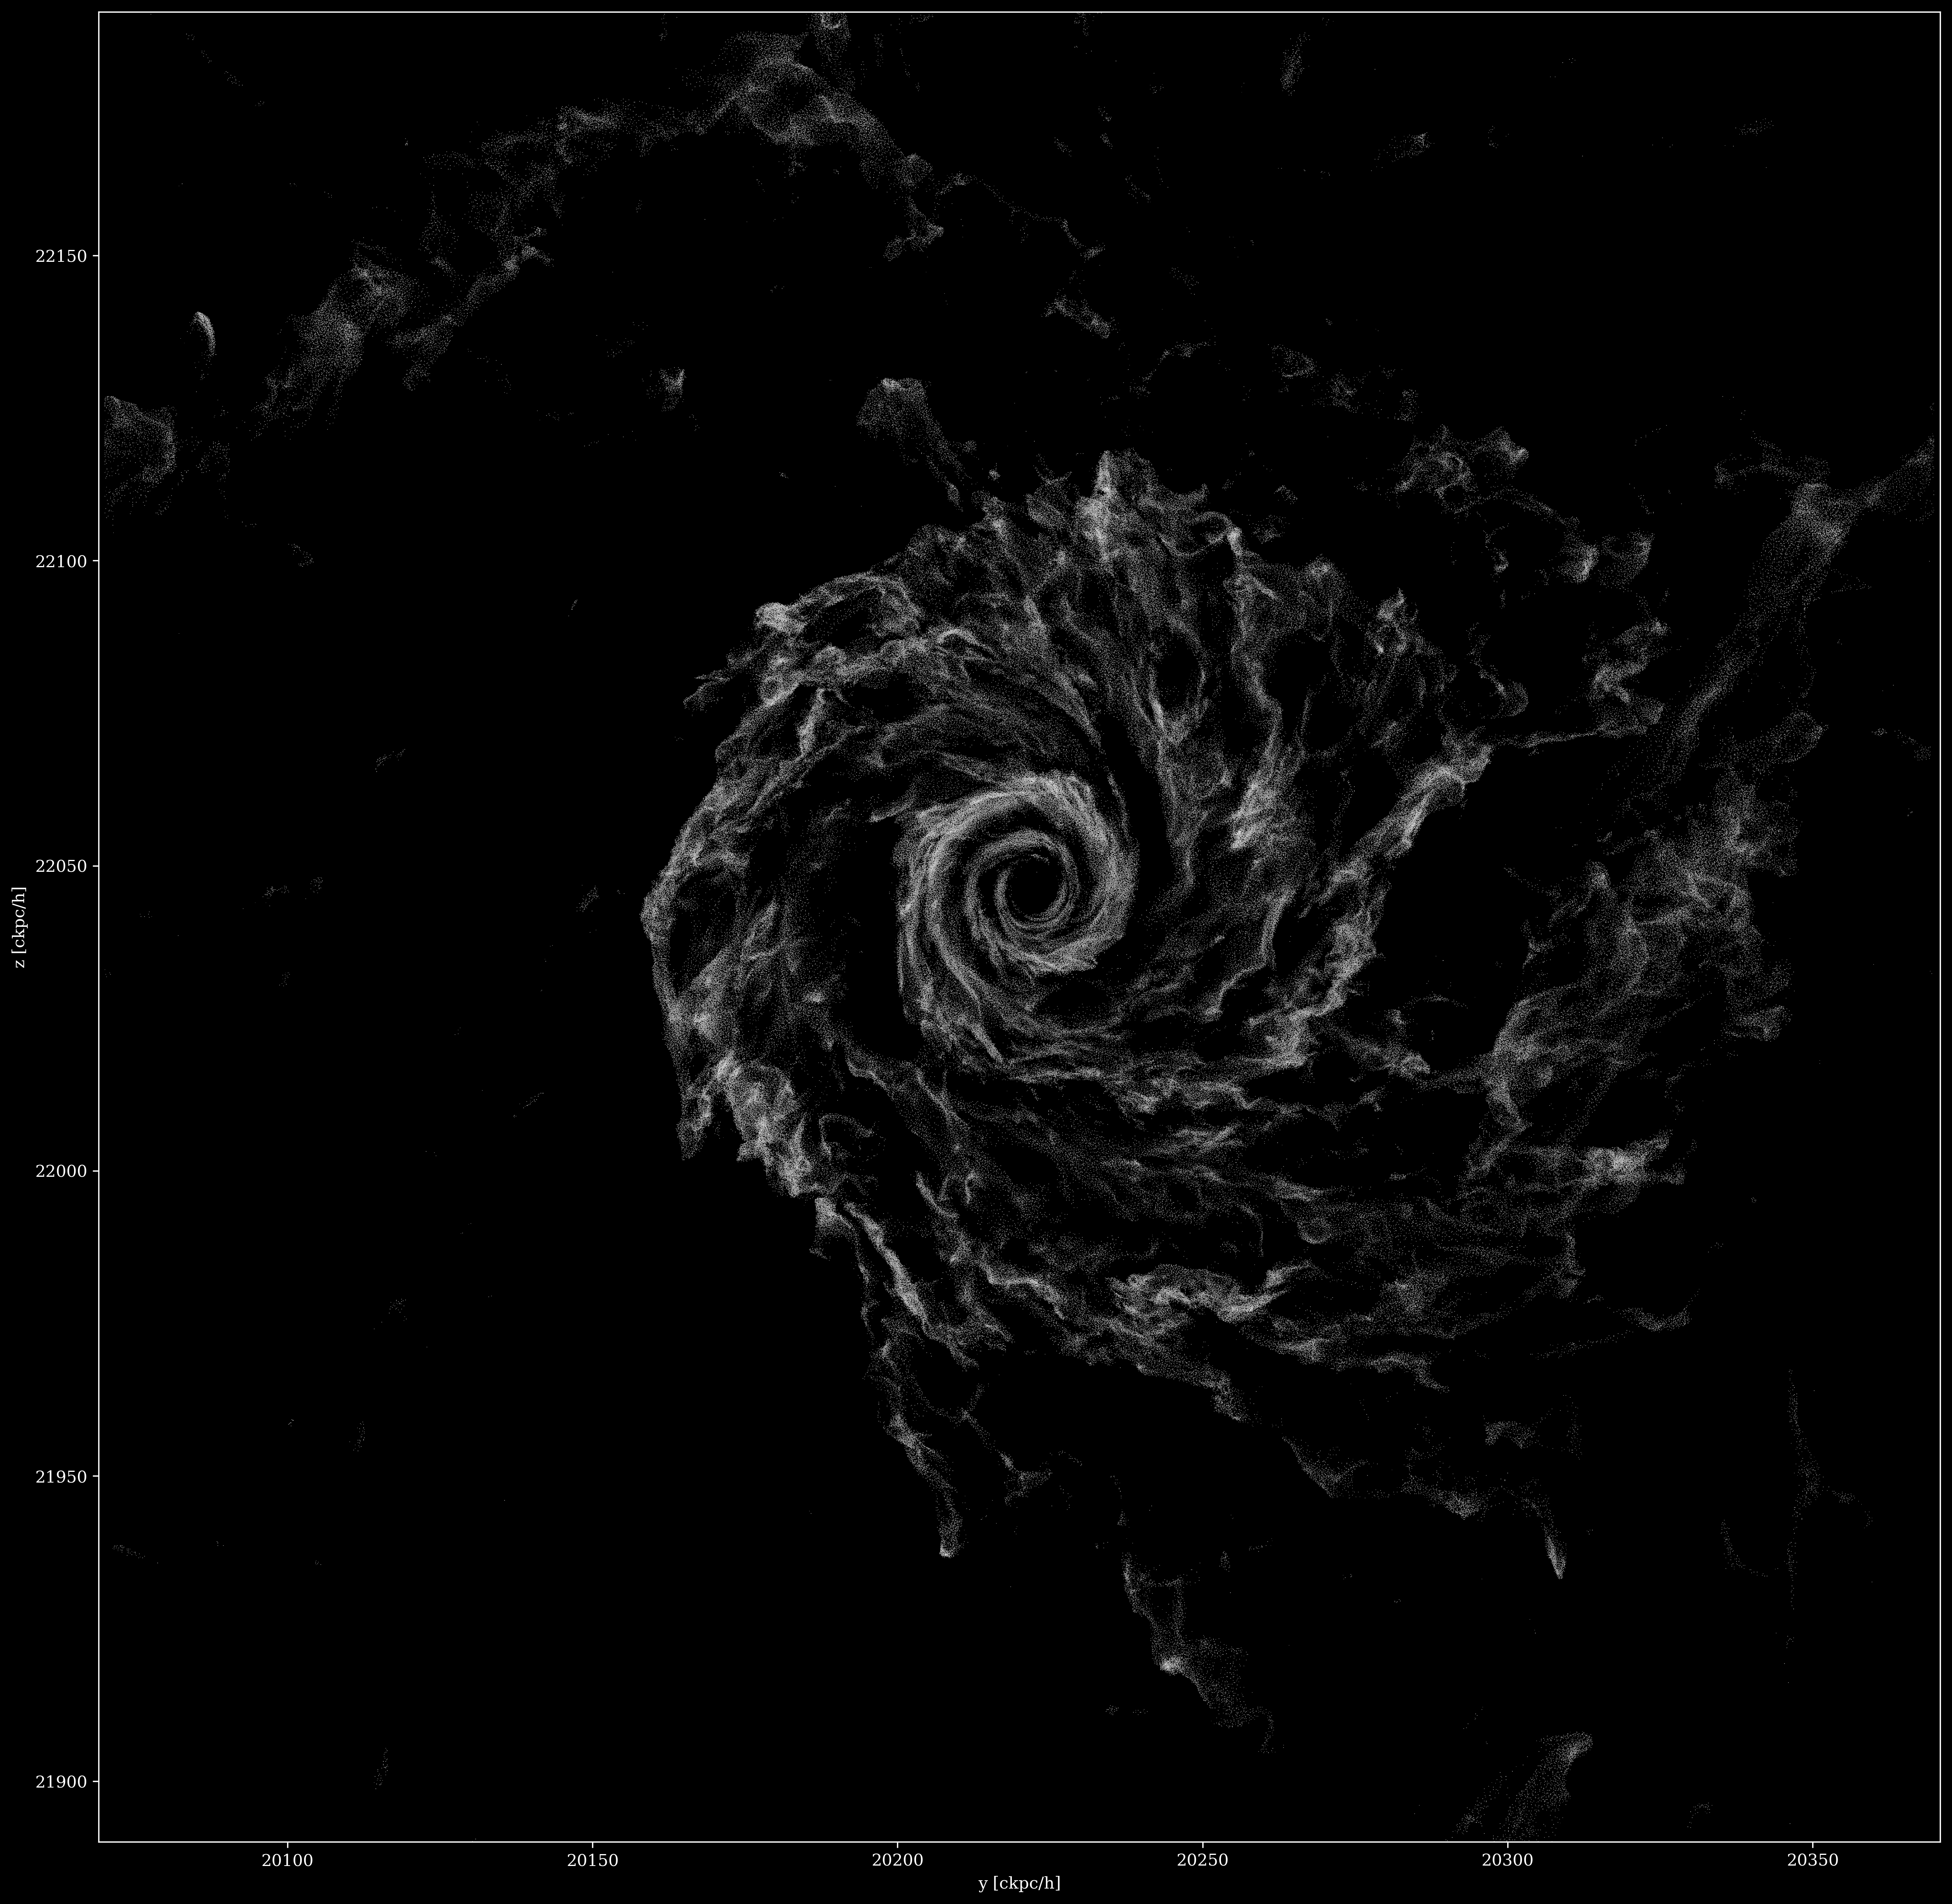

In [28]:
plt.figure(figsize=(20, 20), dpi=300)
plt.style.use("dark_background")
x_range, y_range = cloud.x_range, cloud.y_range
plt.hist2d([cell.Coordinate[1] for cell in cloud.cells], [cell.Coordinate[2] for cell in cloud.cells], norm=mpl.colors.LogNorm(), bins=[int((x_range[1]-x_range[0])*8), int((y_range[1]-y_range[0])*8)], weights=[cell.Mass for cell in cloud.cells],cmin=1e-7,cmap='gray')
plt.xlabel('y [ckpc/h]')
plt.ylabel('z [ckpc/h]')
plt.xlim(cloud.x_range[0],cloud.x_range[1])
plt.ylim(cloud.y_range[0],cloud.y_range[1])
#plt.axes().get_xaxis().set_visible(False)
#plt.axes().get_yaxis().set_visible(False)
plt.axis('equal')